# Denoising Dirty Documents with AutoEncoders 📜➡📃

- dataset - https://www.kaggle.com/c/denoising-dirty-documents/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # ไว้แสดง progress bar

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
%ls '/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents'

test/  train/  train_cleaned/


In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents/'

In [ ]:
# imgW, imgH = 300, 240
imgW, imgH = 540, 420

In [ ]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

print(f'X Train: {len(train_img)} , Y Train: {len(train_cleaned_img)}')
print('X Test:', len(test_img))

train_img[:5]

X Train: 144 , Y Train: 144
X Test: 72


['101.png', '102.png', '104.png', '105.png', '107.png']

(420, 540, 1)


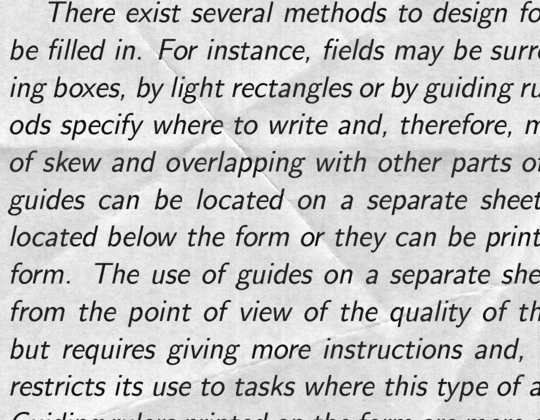

In [ ]:
img = load_img(path+'train/'+train_img[0], target_size=(imgH, imgW),
              color_mode='grayscale')
print(img_to_array(img).shape)

img

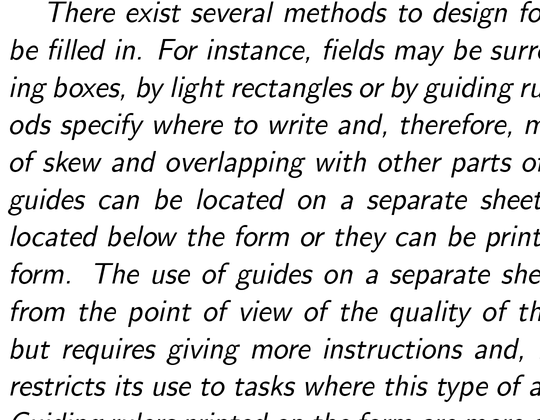

In [ ]:
img = load_img(path+'train_cleaned/'+train_img[0], target_size=(imgH, imgW))
img

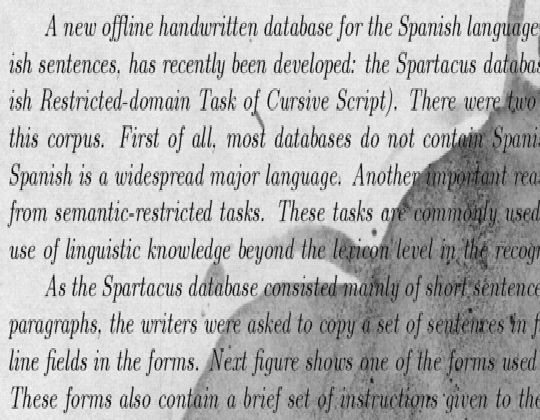

In [ ]:
img = load_img(path+'test/'+test_img[0], target_size=(imgH, imgW))
img

In [ ]:
def process_image(file):
    img = load_img(file, target_size=(imgH, imgW), color_mode='grayscale')
    img = img_to_array(img)
    img = img/255.0
    return img

In [ ]:
train = []
train_cleaned = []
test = []

for f in tqdm(train_img):
    train.append(process_image(path + 'train/' + f))

for f in tqdm(train_cleaned_img):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in tqdm(test_img):
    test.append(process_image(path + 'test/' + f))


100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


In [ ]:
print('Train0 shape:', train[0].shape)

Train0 shape: (420, 540, 1)


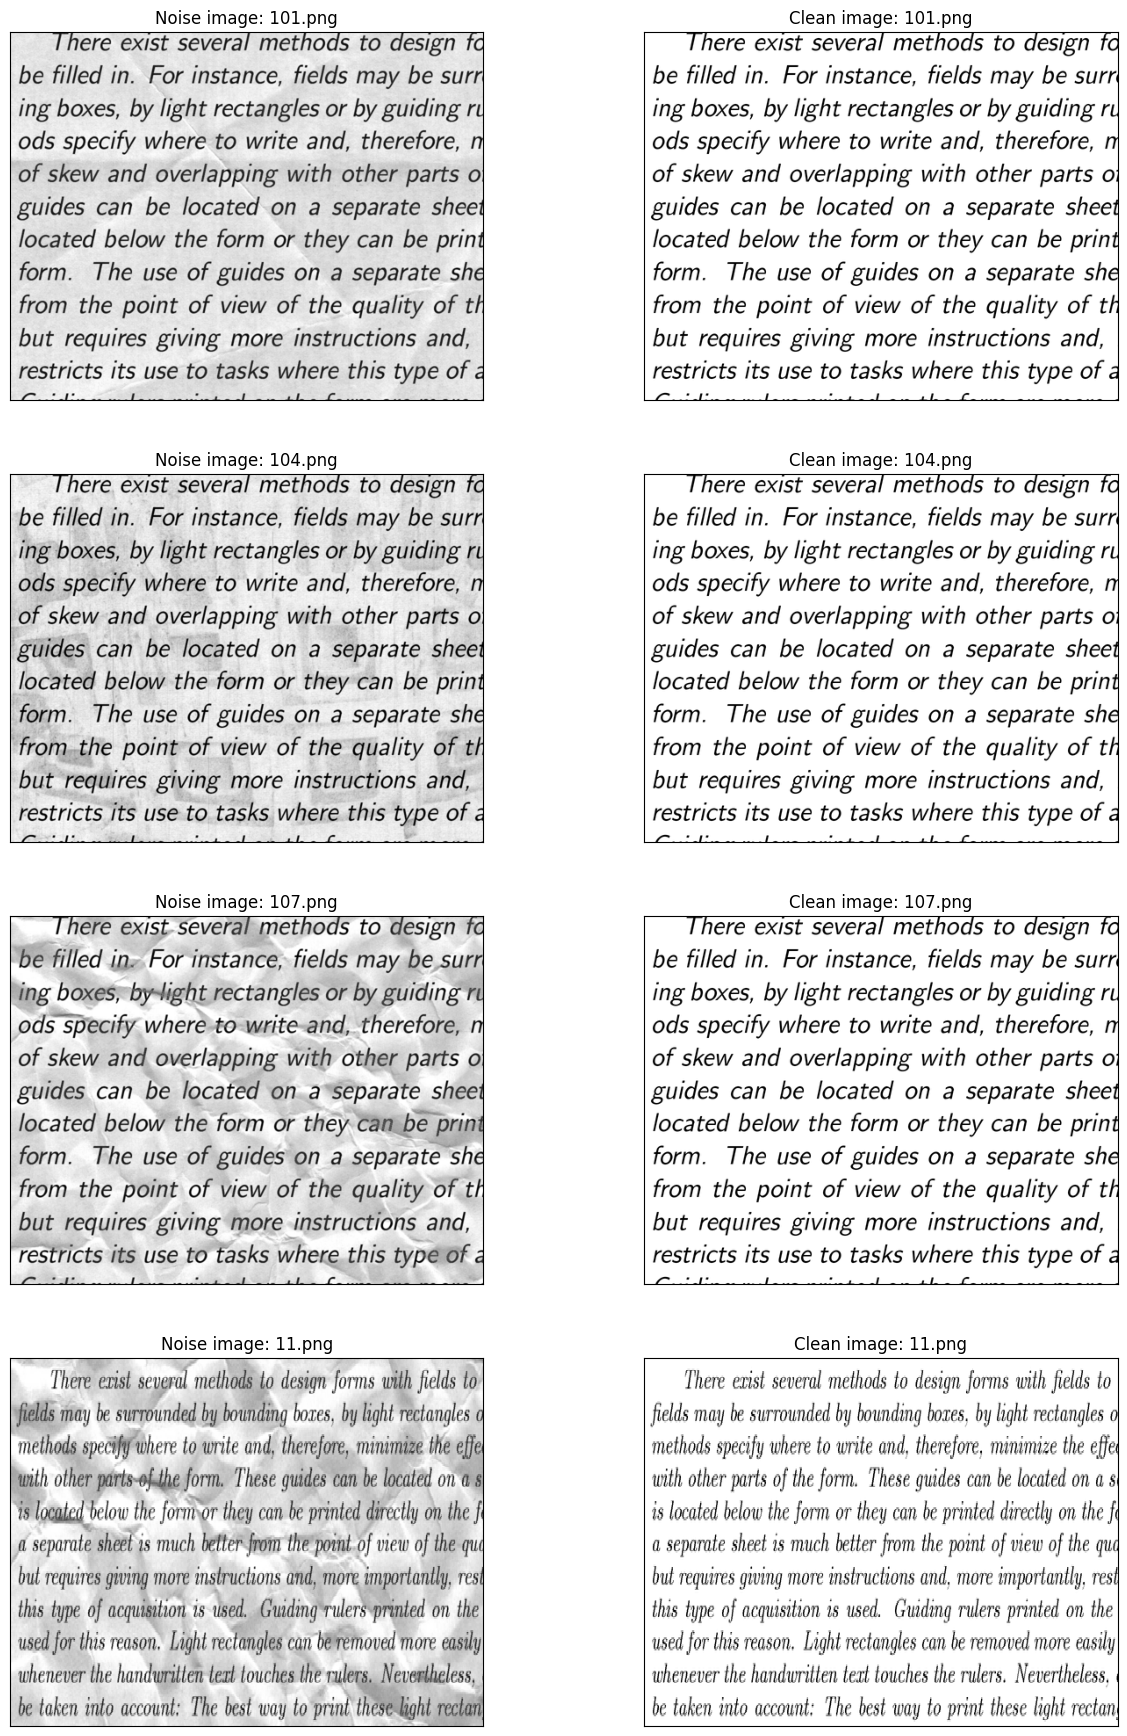

In [ ]:
plt.figure(figsize=(15,22))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Clean image: {}'.format(train_img[i]))

plt.show()

In [ ]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

X_train.shape, X_val.shape

((122, 420, 540, 1), (22, 420, 540, 1))

### Model

In [ ]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = Sequential([
#             InputLayer(input_shape=(imgW, imgH, 1)),
            Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            # BatchNormalization(),
            # MaxPooling2D((2, 2), padding='same'),
            Dropout(0.4) ])

        self.decoder = Sequential([
            Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def build(self, input_shape):
        # กำหนด input shape ในเมธอด build
        self.encoder.build(input_shape)
        self.decoder.build((None, input_shape[1] // 4, input_shape[2] // 4, 128))
        super(Denoise, self).build(input_shape)

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=20)
history = autoencoder.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 27s 1s/step - loss: 0.5960 - val_loss: 0.3364
Epoch 2/100
8/8 [==============================] - 4s 543ms/step - loss: 0.3596 - val_loss: 0.3333
Epoch 3/100
8/8 [==============================] - 4s 547ms/step - loss: 0.3337 - val_loss: 0.3211
Epoch 4/100
8/8 [==============================] - 4s 548ms/step - loss: 0.3171 - val_loss: 0.3158
Epoch 5/100
8/8 [==============================] - 4s 565ms/step - loss: 0.3052 - val_loss: 0.3009
Epoch 6/100
8/8 [==============================] - 5s 568ms/step - loss: 0.2877 - val_loss: 0.2726
Epoch 7/100
8/8 [==============================] - 5s 569ms/step - loss: 0.2575 - val_loss: 0.2350
Epoch 8/100
8/8 [==============================] - 5s 582ms/step - loss: 0.2234 - val_loss: 0.2075
Epoch 9/100
8/8 [==============================] - 5s 584ms/step - loss: 0.2032 - val_loss: 0.1958
Epoch 10/100
8/8 [==============================] - 5s 596ms/step - loss: 0.1916 - val_loss: 0.1854
Epoch 11/10

In [ ]:
# บันทึกโมเดลทั้งหมด
autoencoder.save('autoencoder_model')

In [ ]:
!zip -r /content/autoencoder_model.zip /content/autoencoder_model

  adding: content/autoencoder_model/ (stored 0%)
  adding: content/autoencoder_model/saved_model.pb (deflated 88%)
  adding: content/autoencoder_model/assets/ (stored 0%)
  adding: content/autoencoder_model/variables/ (stored 0%)
  adding: content/autoencoder_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/autoencoder_model/variables/variables.index (deflated 64%)
  adding: content/autoencoder_model/keras_metadata.pb (deflated 91%)
  adding: content/autoencoder_model/fingerprint.pb (stored 0%)


In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 210, 270, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 135, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 105, 135, 128)     0         
                                                                 
Total params: 74496 (291.00 KB)
Trainable params: 74496 (291.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 210, 270, 128)     147584    
 anspose)                                                     

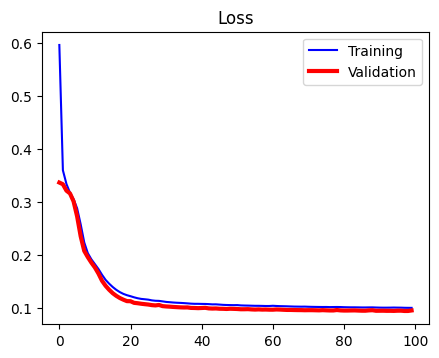

In [ ]:
plt.figure(figsize=(5, 3.8))
plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], 'r', lw=3, label="Validation")
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# clean test images
Y_pred = autoencoder.predict(X_test, batch_size=16)

5/5 [==============================] - 2s 446ms/step


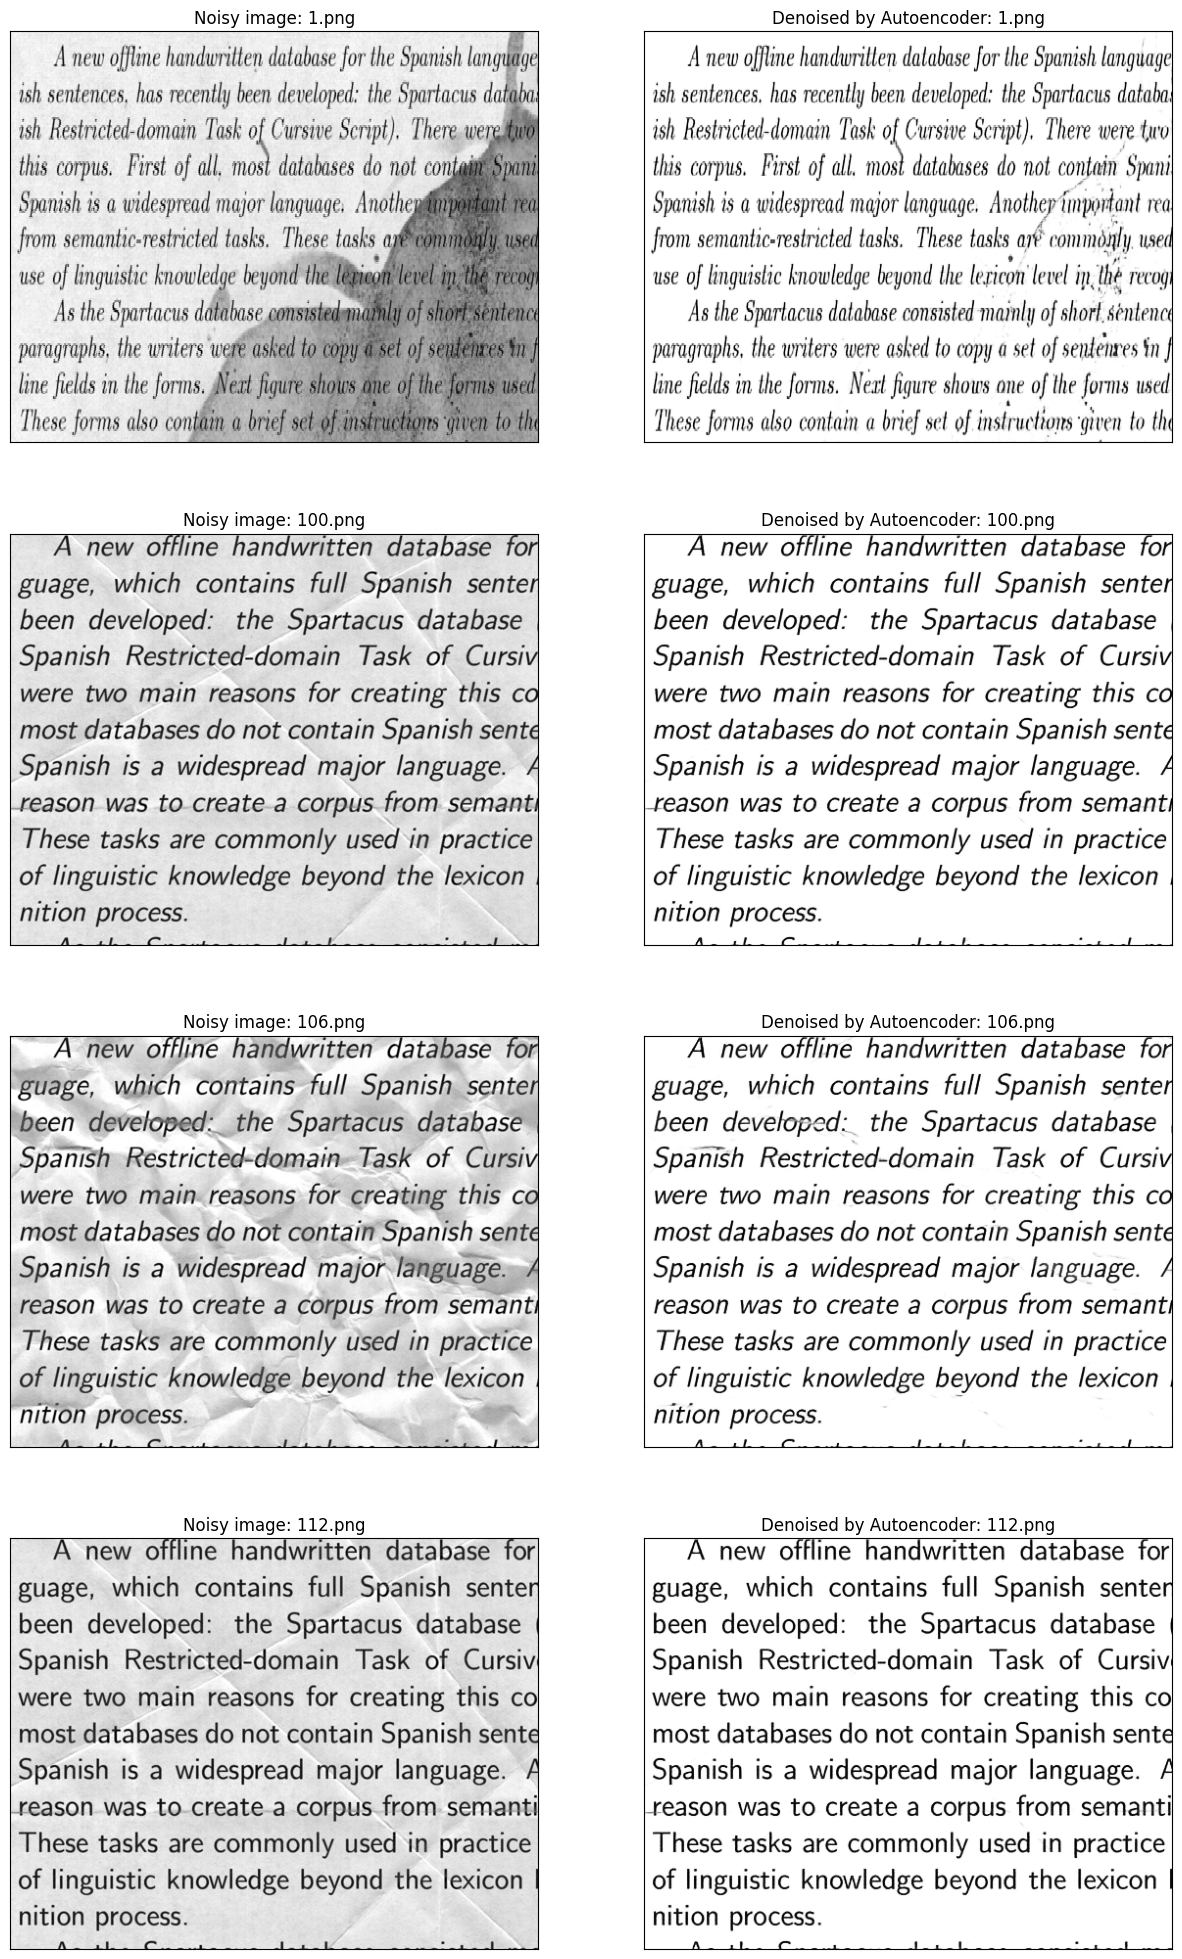

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by Autoencoder: {}'.format(test_img[i]))

plt.show()

## clean Text

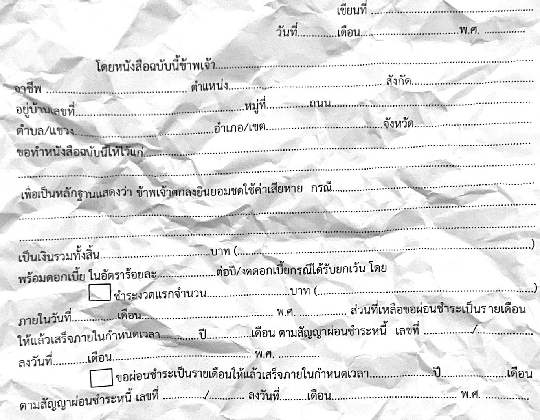

In [ ]:
img = load_img('S__331284511.jpg', target_size=(imgH, imgW), color_mode='grayscale')
img

In [ ]:
img = img_to_array(img)
img = img/255.0
print(img.shape)
print(np.max(img), np.min(img))

(420, 540, 1)
1.0 0.0


In [ ]:
img = np.expand_dims(img, axis=0)
img.shape   #

(1, 420, 540, 1)

1/1 [==============================] - 0s 20ms/step
(420, 540)


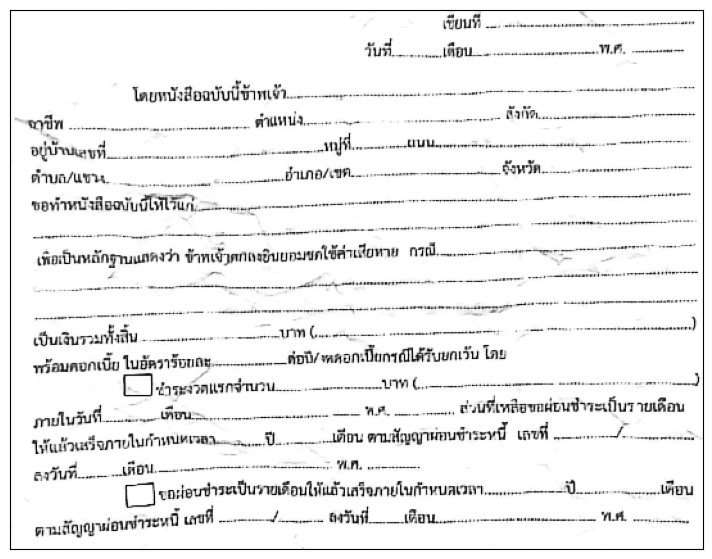

In [ ]:
Y_pred = autoencoder.predict(img)
Y_pred = np.squeeze(Y_pred)
print(Y_pred.shape)

plt.figure(figsize=(10, 7))
plt.imshow(Y_pred, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

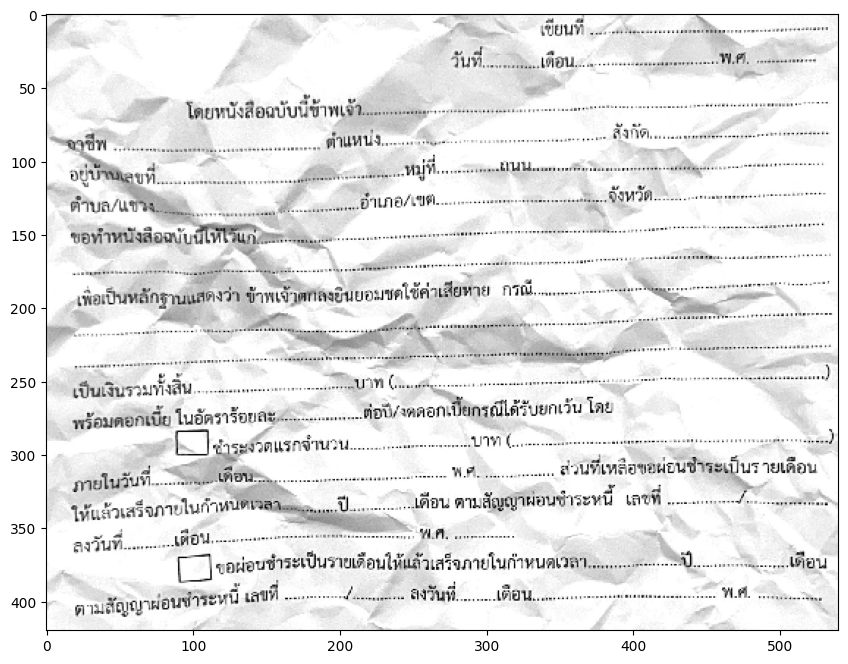

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

## load

In [3]:
!unzip /content/autoencoder_model.zip -d /content/autoencoder_model

Archive:  /content/autoencoder_model.zip
   creating: /content/autoencoder_model/autoencoder_model/
   creating: /content/autoencoder_model/autoencoder_model/assets/
   creating: /content/autoencoder_model/autoencoder_model/content/
  inflating: /content/autoencoder_model/autoencoder_model/fingerprint.pb  
  inflating: /content/autoencoder_model/autoencoder_model/keras_metadata.pb  
  inflating: /content/autoencoder_model/autoencoder_model/saved_model.pb  
   creating: /content/autoencoder_model/autoencoder_model/variables/
  inflating: /content/autoencoder_model/autoencoder_model/variables/variables.data-00000-of-00001  
  inflating: /content/autoencoder_model/autoencoder_model/variables/variables.index  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # ไว้แสดง progress bar

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
from tensorflow.keras.models import load_model

# โหลดโมเดล
loaded_autoencoder = load_model('/content/autoencoder_model/autoencoder_model/')

In [5]:
# imgW, imgH = 300, 240
imgW, imgH = 540, 420

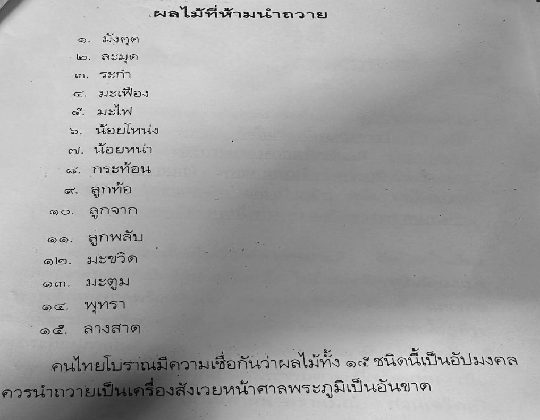

In [8]:
img = load_img('/content/111443_0.jpg', target_size=(imgH, imgW), color_mode='grayscale')
img

In [9]:
img = img_to_array(img)
img = img/255.0
print(img.shape)
print(np.max(img), np.min(img))

(420, 540, 1)
1.0 0.0


In [10]:
img = np.expand_dims(img, axis=0)
img.shape   #

(1, 420, 540, 1)

1/1 [==============================] - 8s 8s/step
(420, 540)


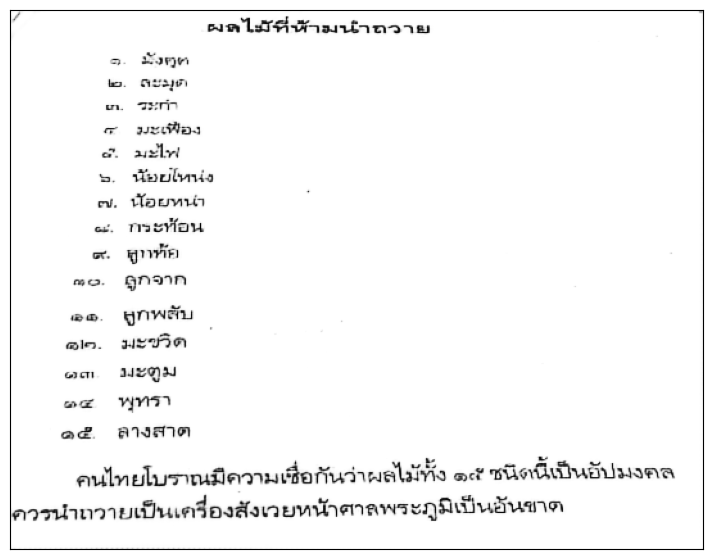

In [11]:
Y_pred = loaded_autoencoder.predict(img) # เรียกใช้ loaded_autoencoder ที่ load มาก่อนหน้านี้
Y_pred = np.squeeze(Y_pred)
print(Y_pred.shape)

plt.figure(figsize=(10, 7))
plt.imshow(Y_pred, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

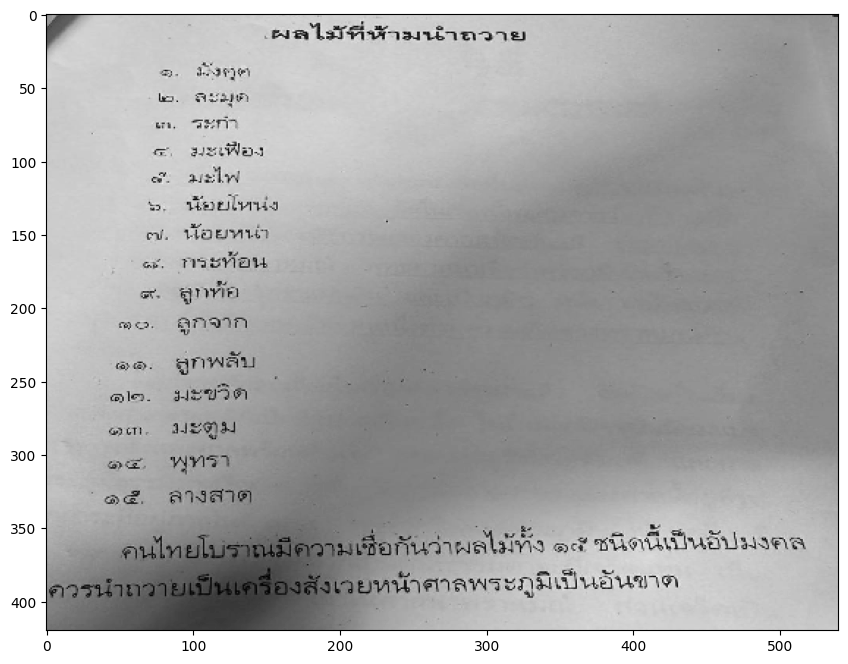

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(np.squeeze(img), cmap='gray')
plt.show()